<a href="https://colab.research.google.com/github/habibarezq/ML-Assignments-25/blob/main/Assignment-2/notebooks/custom_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [32]:
import numpy as np
import torch
import torch.nn as nn           # imports common layers
import torch.nn.functional as F # provides functional versions of activations like ReLU
import torch.optim as optim     # provides optimization algorithms like SGD
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
from google.colab import files
uploaded = files.upload()
from nn_manual import NNDropout , NNBatchNormalized , NNDropoutBatchNormalized

**1. Data Preparation**

In [34]:
# a simple transform to convert images to tensors and normalize to [0,1]
transform = transforms.ToTensor()
# download MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [35]:
# combine train+test to apply a custom stratified split
X_full = torch.cat([mnist_train.data, mnist_test.data], dim=0).float() / 255.0   # shape: (70000, 28, 28)
y_full = torch.cat([mnist_train.targets, mnist_test.targets], dim=0)

# data splitting
X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.20, stratify=y_full, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

Flatten Images

In [36]:
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

Create DataLoaders

In [37]:
train_loader = DataLoader(
    TensorDataset(X_train_flat, y_train),
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_flat, y_val),
    batch_size=64,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_flat, y_test),
    batch_size=64,
    shuffle=False
)


**2. Neural Network Implementation**

Architecture

In [38]:
class CustomFeedforwardNN(nn.Module):
  # 1st hidden layer: 128 neurons, 2nd hidden layer: 64 neurons
    def __init__(self, input_size=784, hidden1_size=128, hidden2_size=64, output_size=10):

        super(CustomFeedforwardNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

        # initialize weights with Xavier initialization (helps keep gradients stable)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        # initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x): # x is input tensor of size (batch size, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # output tensor of size (batch size, 10)


Training and Visualization

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model_once(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):
    model.to(device) # transfer to chosen device
    criterion = nn.CrossEntropyLoss()  # cross-entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # SGD is used to optimize parameters
    # store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        # training mode (enable features like dropout)
        model.train()
        # initialize accumulators for batch loss, correct predictions and total samples processed
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # move batch inputs and labels to device
            optimizer.zero_grad()   # reset
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate loss comparing outputs to labels
            loss.backward()         # compute gradients via backpropagation
            optimizer.step()        # update model weights
            running_loss += loss.item() * inputs.size(0) # accumulate total loss (weighted by batch size)
            _, predicted = torch.max(outputs, 1) # calculate predicted class labels
            total += labels.size(0) # total samples processed
            correct += (predicted == labels).sum().item() # calculate correct predictions
        train_loss = running_loss / total
        train_acc = correct / total
        # validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

Multiple Training Runs with Error Bars and Convergence Analysis

In [40]:
# run the training process multiple times according to runs variable
def train_multiple_times(model_class, train_loader, val_loader, epochs=10, learning_rate=0.01, runs=5):
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []

    for r in range(runs):
        print(f"\nRun {r+1}/{runs}")
        # independent model for each training run
        model = model_class()
        # collect training and validation losses and accuracies each run
        train_losses, val_losses, train_accuracies, val_accuracies = train_model_once(
            model, train_loader, val_loader, epochs, learning_rate, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    # convert to numpy arrays for easier calculations
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accuracies = np.array(all_train_accuracies)
    all_val_accuracies = np.array(all_val_accuracies)

    # mean and std deviation for error bars
    mean_train_loss = np.mean(all_train_losses, axis=0)
    std_train_loss = np.std(all_train_losses, axis=0)
    mean_val_loss = np.mean(all_val_losses, axis=0)
    std_val_loss = np.std(all_val_losses, axis=0)
    mean_train_acc = np.mean(all_train_accuracies, axis=0)
    std_train_acc = np.std(all_train_accuracies, axis=0)
    mean_val_acc = np.mean(all_val_accuracies, axis=0)
    std_val_acc = np.std(all_val_accuracies, axis=0)

    # plot loss with error bars
    epochs_range = range(1, epochs + 1) # used for x-axis
    plt.figure(figsize=(10,5))
    plt.errorbar(epochs_range, mean_train_loss, yerr=std_train_loss, label='Training Loss')
    plt.errorbar(epochs_range, mean_val_loss, yerr=std_val_loss, label='Validation Loss')
    plt.title("Loss over Epochs with Error Bars")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plot accuracy with error bars
    plt.figure(figsize=(10,5))
    plt.errorbar(epochs_range, mean_train_acc, yerr=std_train_acc, label='Training Accuracy')
    plt.errorbar(epochs_range, mean_val_acc, yerr=std_val_acc, label='Validation Accuracy')
    plt.title("Accuracy over Epochs with Error Bars")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # convergence analysis: find epoch where validation loss change is minimal
    val_loss_diff = np.abs(np.diff(mean_val_loss))
    convergence_epoch = np.argmin(val_loss_diff) + 1
    print(f"Convergence epoch: {convergence_epoch}")



Run 1/5
Epoch 1/10 Train Loss: 1.0756 Train Acc: 0.7227 Val Loss: 0.5188 Val Acc: 0.8654
Epoch 2/10 Train Loss: 0.4280 Train Acc: 0.8831 Val Loss: 0.3709 Val Acc: 0.8971
Epoch 3/10 Train Loss: 0.3419 Train Acc: 0.9042 Val Loss: 0.3216 Val Acc: 0.9104
Epoch 4/10 Train Loss: 0.3022 Train Acc: 0.9146 Val Loss: 0.2947 Val Acc: 0.9156
Epoch 5/10 Train Loss: 0.2759 Train Acc: 0.9215 Val Loss: 0.2704 Val Acc: 0.9234
Epoch 6/10 Train Loss: 0.2560 Train Acc: 0.9275 Val Loss: 0.2511 Val Acc: 0.9291
Epoch 7/10 Train Loss: 0.2394 Train Acc: 0.9320 Val Loss: 0.2412 Val Acc: 0.9331
Epoch 8/10 Train Loss: 0.2255 Train Acc: 0.9356 Val Loss: 0.2260 Val Acc: 0.9355
Epoch 9/10 Train Loss: 0.2129 Train Acc: 0.9389 Val Loss: 0.2172 Val Acc: 0.9373
Epoch 10/10 Train Loss: 0.2012 Train Acc: 0.9424 Val Loss: 0.2100 Val Acc: 0.9412

Run 2/5
Epoch 1/10 Train Loss: 1.0214 Train Acc: 0.7386 Val Loss: 0.5086 Val Acc: 0.8683
Epoch 2/10 Train Loss: 0.4238 Train Acc: 0.8837 Val Loss: 0.3737 Val Acc: 0.8954
Epoch 3/1

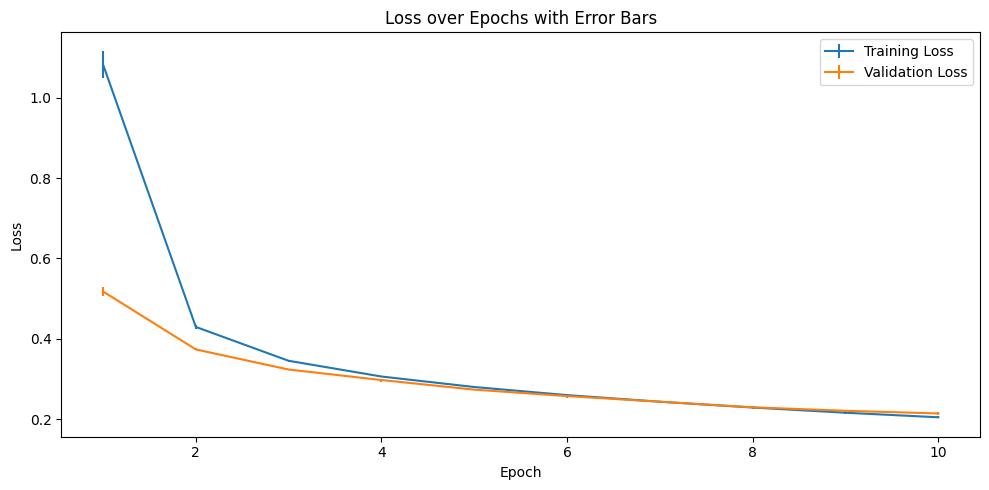

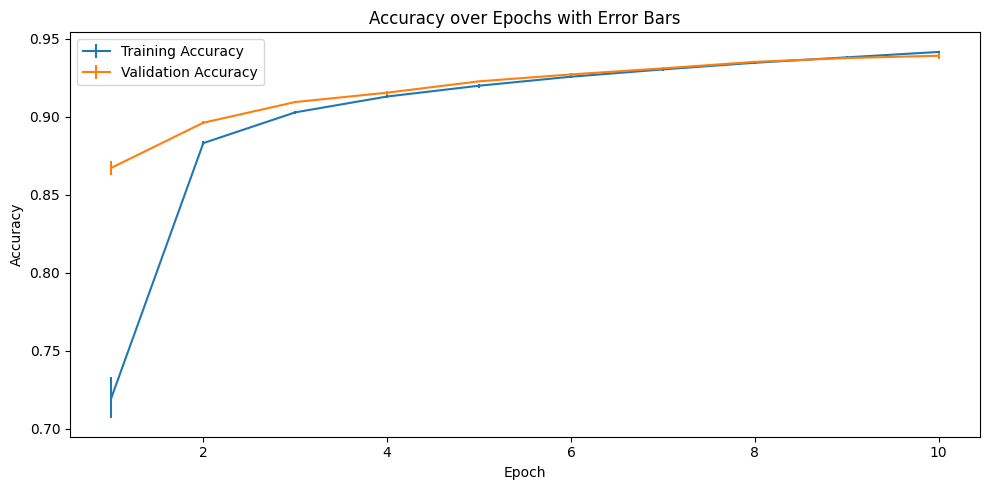

Convergence epoch: 9


In [41]:
train_multiple_times(
    model_class=CustomFeedforwardNN,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    learning_rate=0.01,
    runs=5
)

# Part D2: NN with Dropout Layer

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dropout_rates = [0.1, 0.3, 0.5, 0.7]
dropout_results = {}

for rate in dropout_rates:
    print(f"Training with dropout rate: {rate}")
    model = NNDropout(dropout_rate=rate)

    train_losses, val_losses, train_accs, val_accs = train_model_once(
        model,
        train_loader,
        val_loader,
        epochs=10,
        learning_rate=0.01,
        device=device
    )
    dropout_results[rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs
    }


Training with dropout rate: 0.1
Epoch 1/10 Train Loss: 2.0063 Train Acc: 0.4811 Val Loss: 1.2988 Val Acc: 0.7559
Epoch 2/10 Train Loss: 0.8349 Train Acc: 0.7869 Val Loss: 0.5546 Val Acc: 0.8587
Epoch 3/10 Train Loss: 0.5258 Train Acc: 0.8469 Val Loss: 0.4256 Val Acc: 0.8846
Epoch 4/10 Train Loss: 0.4331 Train Acc: 0.8746 Val Loss: 0.3690 Val Acc: 0.8971
Epoch 5/10 Train Loss: 0.3915 Train Acc: 0.8863 Val Loss: 0.3375 Val Acc: 0.9043
Epoch 6/10 Train Loss: 0.3596 Train Acc: 0.8944 Val Loss: 0.3192 Val Acc: 0.9111
Epoch 7/10 Train Loss: 0.3382 Train Acc: 0.9026 Val Loss: 0.3007 Val Acc: 0.9146
Epoch 8/10 Train Loss: 0.3167 Train Acc: 0.9082 Val Loss: 0.2851 Val Acc: 0.9190
Epoch 9/10 Train Loss: 0.3009 Train Acc: 0.9130 Val Loss: 0.2710 Val Acc: 0.9226
Epoch 10/10 Train Loss: 0.2846 Train Acc: 0.9162 Val Loss: 0.2578 Val Acc: 0.9266
Training with dropout rate: 0.3
Epoch 1/10 Train Loss: 2.0762 Train Acc: 0.4097 Val Loss: 1.4776 Val Acc: 0.6619
Epoch 2/10 Train Loss: 1.0146 Train Acc: 0.7

In [43]:
# Analysis of overfitting for dropout models
for rate in dropout_rates:
    final_train_acc = dropout_results[rate]['train_accuracies'][-1]
    final_val_acc = dropout_results[rate]['val_accuracies'][-1]
    generalization_gap = final_train_acc - final_val_acc

    print(f"Dropout Rate {rate}:")
    print(f"  Train Accuracy: {final_train_acc:.4f}")
    print(f"  Val Accuracy: {final_val_acc:.4f}")
    print(f"  Generalization Gap: {generalization_gap:.4f}")
    print()

Dropout Rate 0.1:
  Train Accuracy: 0.9162
  Val Accuracy: 0.9266
  Generalization Gap: -0.0104

Dropout Rate 0.3:
  Train Accuracy: 0.9072
  Val Accuracy: 0.9266
  Generalization Gap: -0.0194

Dropout Rate 0.5:
  Train Accuracy: 0.8929
  Val Accuracy: 0.9246
  Generalization Gap: -0.0317

Dropout Rate 0.7:
  Train Accuracy: 0.8517
  Val Accuracy: 0.9120
  Generalization Gap: -0.0603



## Dropout analysis

Notice as Dropout increases , the number of active neurons decrease , training is harder , training accuracy decrease , regularization increases , gap between val and train becomes more negative

## Training Loss


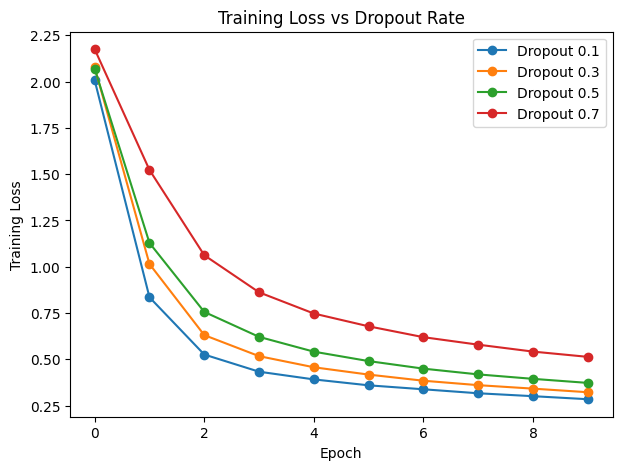

In [44]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results[rate]['train_losses'], label=f'Dropout {rate}', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Dropout Rate')
plt.legend()
plt.show()

## Validation Loss

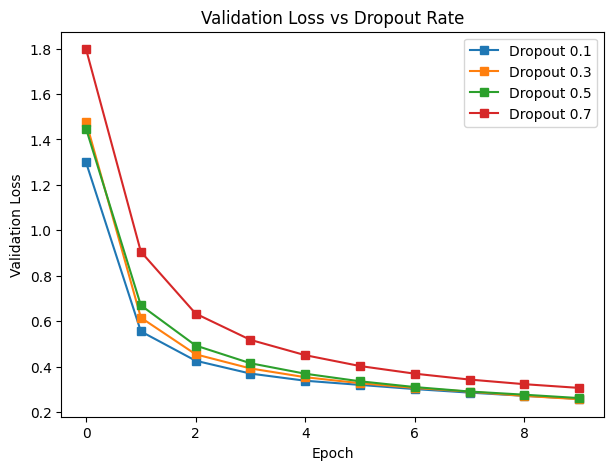

In [45]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results[rate]['val_losses'], label=f'Dropout {rate}', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Dropout Rate')
plt.legend()
plt.show()

## Batch Normalization

In [46]:
batchnorm_model = NNBatchNormalized()
batch_results=dict()

train_losses, val_losses, train_accs, val_accs = train_model_once(
    batchnorm_model, train_loader, val_loader,
    epochs=10, learning_rate=0.01, device=device
)

batch_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accs,
    'val_accuracies': val_accs
}

Epoch 1/10 Train Loss: 0.3911 Train Acc: 0.9025 Val Loss: 0.1948 Val Acc: 0.9478
Epoch 2/10 Train Loss: 0.1651 Train Acc: 0.9564 Val Loss: 0.1476 Val Acc: 0.9586
Epoch 3/10 Train Loss: 0.1167 Train Acc: 0.9690 Val Loss: 0.1147 Val Acc: 0.9660
Epoch 4/10 Train Loss: 0.0919 Train Acc: 0.9753 Val Loss: 0.1030 Val Acc: 0.9695
Epoch 5/10 Train Loss: 0.0728 Train Acc: 0.9800 Val Loss: 0.0982 Val Acc: 0.9709
Epoch 6/10 Train Loss: 0.0590 Train Acc: 0.9848 Val Loss: 0.0915 Val Acc: 0.9724
Epoch 7/10 Train Loss: 0.0481 Train Acc: 0.9881 Val Loss: 0.0878 Val Acc: 0.9738
Epoch 8/10 Train Loss: 0.0404 Train Acc: 0.9904 Val Loss: 0.0848 Val Acc: 0.9744
Epoch 9/10 Train Loss: 0.0350 Train Acc: 0.9918 Val Loss: 0.0800 Val Acc: 0.9756
Epoch 10/10 Train Loss: 0.0293 Train Acc: 0.9941 Val Loss: 0.0821 Val Acc: 0.9752


### Training Stability and Convergence Speed

In [47]:
baseline_model = CustomFeedforwardNN()
baseline_train_losses, baseline_val_losses, baseline_train_accs, baseline_val_accs = train_model_once(
    baseline_model, train_loader, val_loader,
    epochs=10, learning_rate=0.01, device=device
)

baseline_loss_diff = np.abs(np.diff(baseline_val_losses))
batch_loss_diff = np.abs(np.diff(batch_results['val_losses']))

baseline_convergence = np.argmin(baseline_loss_diff) + 1
batch_convergence = np.argmin(batch_loss_diff) + 1

print(f"Baseline convergence epoch: {baseline_convergence}")
print(f"BatchNorm convergence epoch: {batch_convergence}")
print(f"Convergence speedup: {baseline_convergence - batch_convergence} epochs")

Epoch 1/10 Train Loss: 1.0379 Train Acc: 0.7318 Val Loss: 0.5082 Val Acc: 0.8652
Epoch 2/10 Train Loss: 0.4211 Train Acc: 0.8831 Val Loss: 0.3700 Val Acc: 0.8970
Epoch 3/10 Train Loss: 0.3421 Train Acc: 0.9028 Val Loss: 0.3235 Val Acc: 0.9072
Epoch 4/10 Train Loss: 0.3043 Train Acc: 0.9122 Val Loss: 0.2962 Val Acc: 0.9175
Epoch 5/10 Train Loss: 0.2783 Train Acc: 0.9194 Val Loss: 0.2721 Val Acc: 0.9234
Epoch 6/10 Train Loss: 0.2584 Train Acc: 0.9258 Val Loss: 0.2555 Val Acc: 0.9288
Epoch 7/10 Train Loss: 0.2420 Train Acc: 0.9309 Val Loss: 0.2455 Val Acc: 0.9304
Epoch 8/10 Train Loss: 0.2275 Train Acc: 0.9351 Val Loss: 0.2310 Val Acc: 0.9347
Epoch 9/10 Train Loss: 0.2154 Train Acc: 0.9382 Val Loss: 0.2210 Val Acc: 0.9381
Epoch 10/10 Train Loss: 0.2041 Train Acc: 0.9418 Val Loss: 0.2125 Val Acc: 0.9388
Baseline convergence epoch: 9
BatchNorm convergence epoch: 9
Convergence speedup: 0 epochs


## NN With Dropout and Batch Normalization

In [48]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
dropout_results_both = {}

for rate in dropout_rates:
    print(f"Training with dropout rate: {rate}")
    model = NNDropoutBatchNormalized(dropout_rate=rate)

    train_losses, val_losses, train_accs, val_accs = train_model_once(
        model,
        train_loader,
        val_loader,
        epochs=10,
        learning_rate=0.01,
        device=device
    )
    dropout_results_both[rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs
    }


Training with dropout rate: 0.1
Epoch 1/10 Train Loss: 0.4217 Train Acc: 0.8923 Val Loss: 0.2011 Val Acc: 0.9448
Epoch 2/10 Train Loss: 0.1921 Train Acc: 0.9471 Val Loss: 0.1576 Val Acc: 0.9566
Epoch 3/10 Train Loss: 0.1445 Train Acc: 0.9592 Val Loss: 0.1163 Val Acc: 0.9655
Epoch 4/10 Train Loss: 0.1135 Train Acc: 0.9680 Val Loss: 0.1056 Val Acc: 0.9681
Epoch 5/10 Train Loss: 0.0948 Train Acc: 0.9729 Val Loss: 0.1057 Val Acc: 0.9684
Epoch 6/10 Train Loss: 0.0810 Train Acc: 0.9768 Val Loss: 0.0894 Val Acc: 0.9729
Epoch 7/10 Train Loss: 0.0676 Train Acc: 0.9809 Val Loss: 0.0798 Val Acc: 0.9758
Epoch 8/10 Train Loss: 0.0595 Train Acc: 0.9833 Val Loss: 0.0812 Val Acc: 0.9757
Epoch 9/10 Train Loss: 0.0543 Train Acc: 0.9848 Val Loss: 0.0812 Val Acc: 0.9759
Epoch 10/10 Train Loss: 0.0474 Train Acc: 0.9867 Val Loss: 0.0766 Val Acc: 0.9761
Training with dropout rate: 0.3
Epoch 1/10 Train Loss: 0.5219 Train Acc: 0.8571 Val Loss: 0.2297 Val Acc: 0.9371
Epoch 2/10 Train Loss: 0.2580 Train Acc: 0.9

## Analysis

## Training Loss

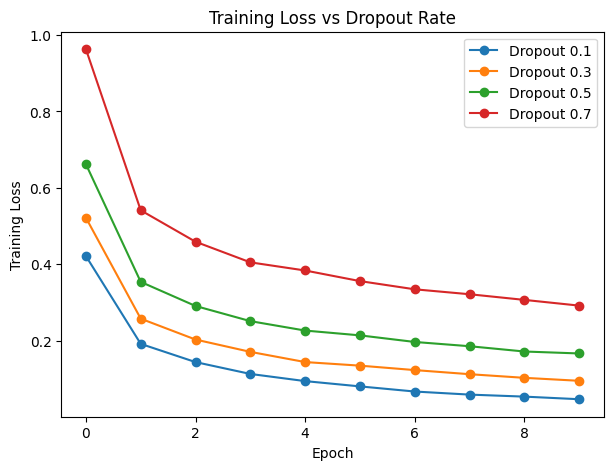

In [49]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results_both[rate]['train_losses'], label=f'Dropout {rate}', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Dropout Rate')
plt.legend()
plt.show()


## Validation Loss

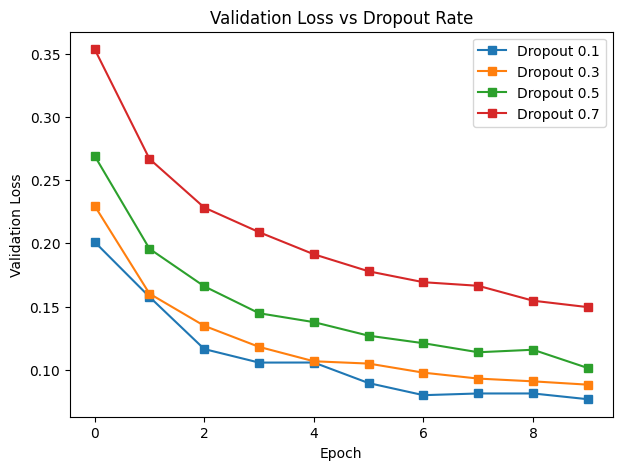

In [50]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results_both[rate]['val_losses'], label=f'Dropout {rate}', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Dropout Rate')
plt.legend()
plt.show()

## Final Comparsion

In [51]:
comparison_data = []

# Normal
comparison_data.append({
    'Model': 'Normal NN',
    'Final Train Acc': baseline_train_accs[-1], # last training accuracy
    'Final Val Acc': baseline_val_accs[-1],
    'Final Val Loss': baseline_val_losses[-1]
})

# Batch Norm only
comparison_data.append({
    'Model': 'BatchNorm Only',
    'Final Train Acc': batch_results['train_accuracies'][-1],
    'Final Val Acc': batch_results['val_accuracies'][-1],
    'Final Val Loss': batch_results['val_losses'][-1]
})

# Dropout only
for rate in dropout_rates:
    comparison_data.append({
        'Model': f'Dropout {rate}',
        'Final Train Acc': dropout_results[rate]['train_accuracies'][-1],
        'Final Val Acc': dropout_results[rate]['val_accuracies'][-1],
        'Final Val Loss': dropout_results[rate]['val_losses'][-1]
    })

# Dropout + BatchNorm
for rate in dropout_rates:
    comparison_data.append({
        'Model': f'Dropout {rate} + BatchNorm',
        'Final Train Acc': dropout_results_both[rate]['train_accuracies'][-1],
        'Final Val Acc': dropout_results_both[rate]['val_accuracies'][-1],
        'Final Val Loss': dropout_results_both[rate]['val_losses'][-1]
    })

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))

                  Model  Final Train Acc  Final Val Acc  Final Val Loss
              Normal NN         0.941833       0.938786        0.212460
         BatchNorm Only         0.994071       0.975214        0.082103
            Dropout 0.1         0.916190       0.926571        0.257768
            Dropout 0.3         0.907167       0.926571        0.256106
            Dropout 0.5         0.892857       0.924571        0.261062
            Dropout 0.7         0.851690       0.912000        0.305878
Dropout 0.1 + BatchNorm         0.986690       0.976071        0.076638
Dropout 0.3 + BatchNorm         0.971429       0.973643        0.088157
Dropout 0.5 + BatchNorm         0.949738       0.968214        0.101311
Dropout 0.7 + BatchNorm         0.915024       0.955286        0.149512


## Comment on final results:
Dropout rate 0.1 combined with Batch Normalization achieves the highest validation accuracy while maintaining good training stability. The light dropout provides just enough regularization without hindering the model's capacity to learn